In [33]:
#!pip install mlxtend

In [34]:
import pandas as pd
from mlxtend.frequent_patterns import apriori , association_rules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display

In [35]:
train=pd.read_csv("../../DataFiles/airline-train.csv")
# dropping the unnamed column (index) and id column
train=train.drop([train.columns[0],'id'], axis=1)

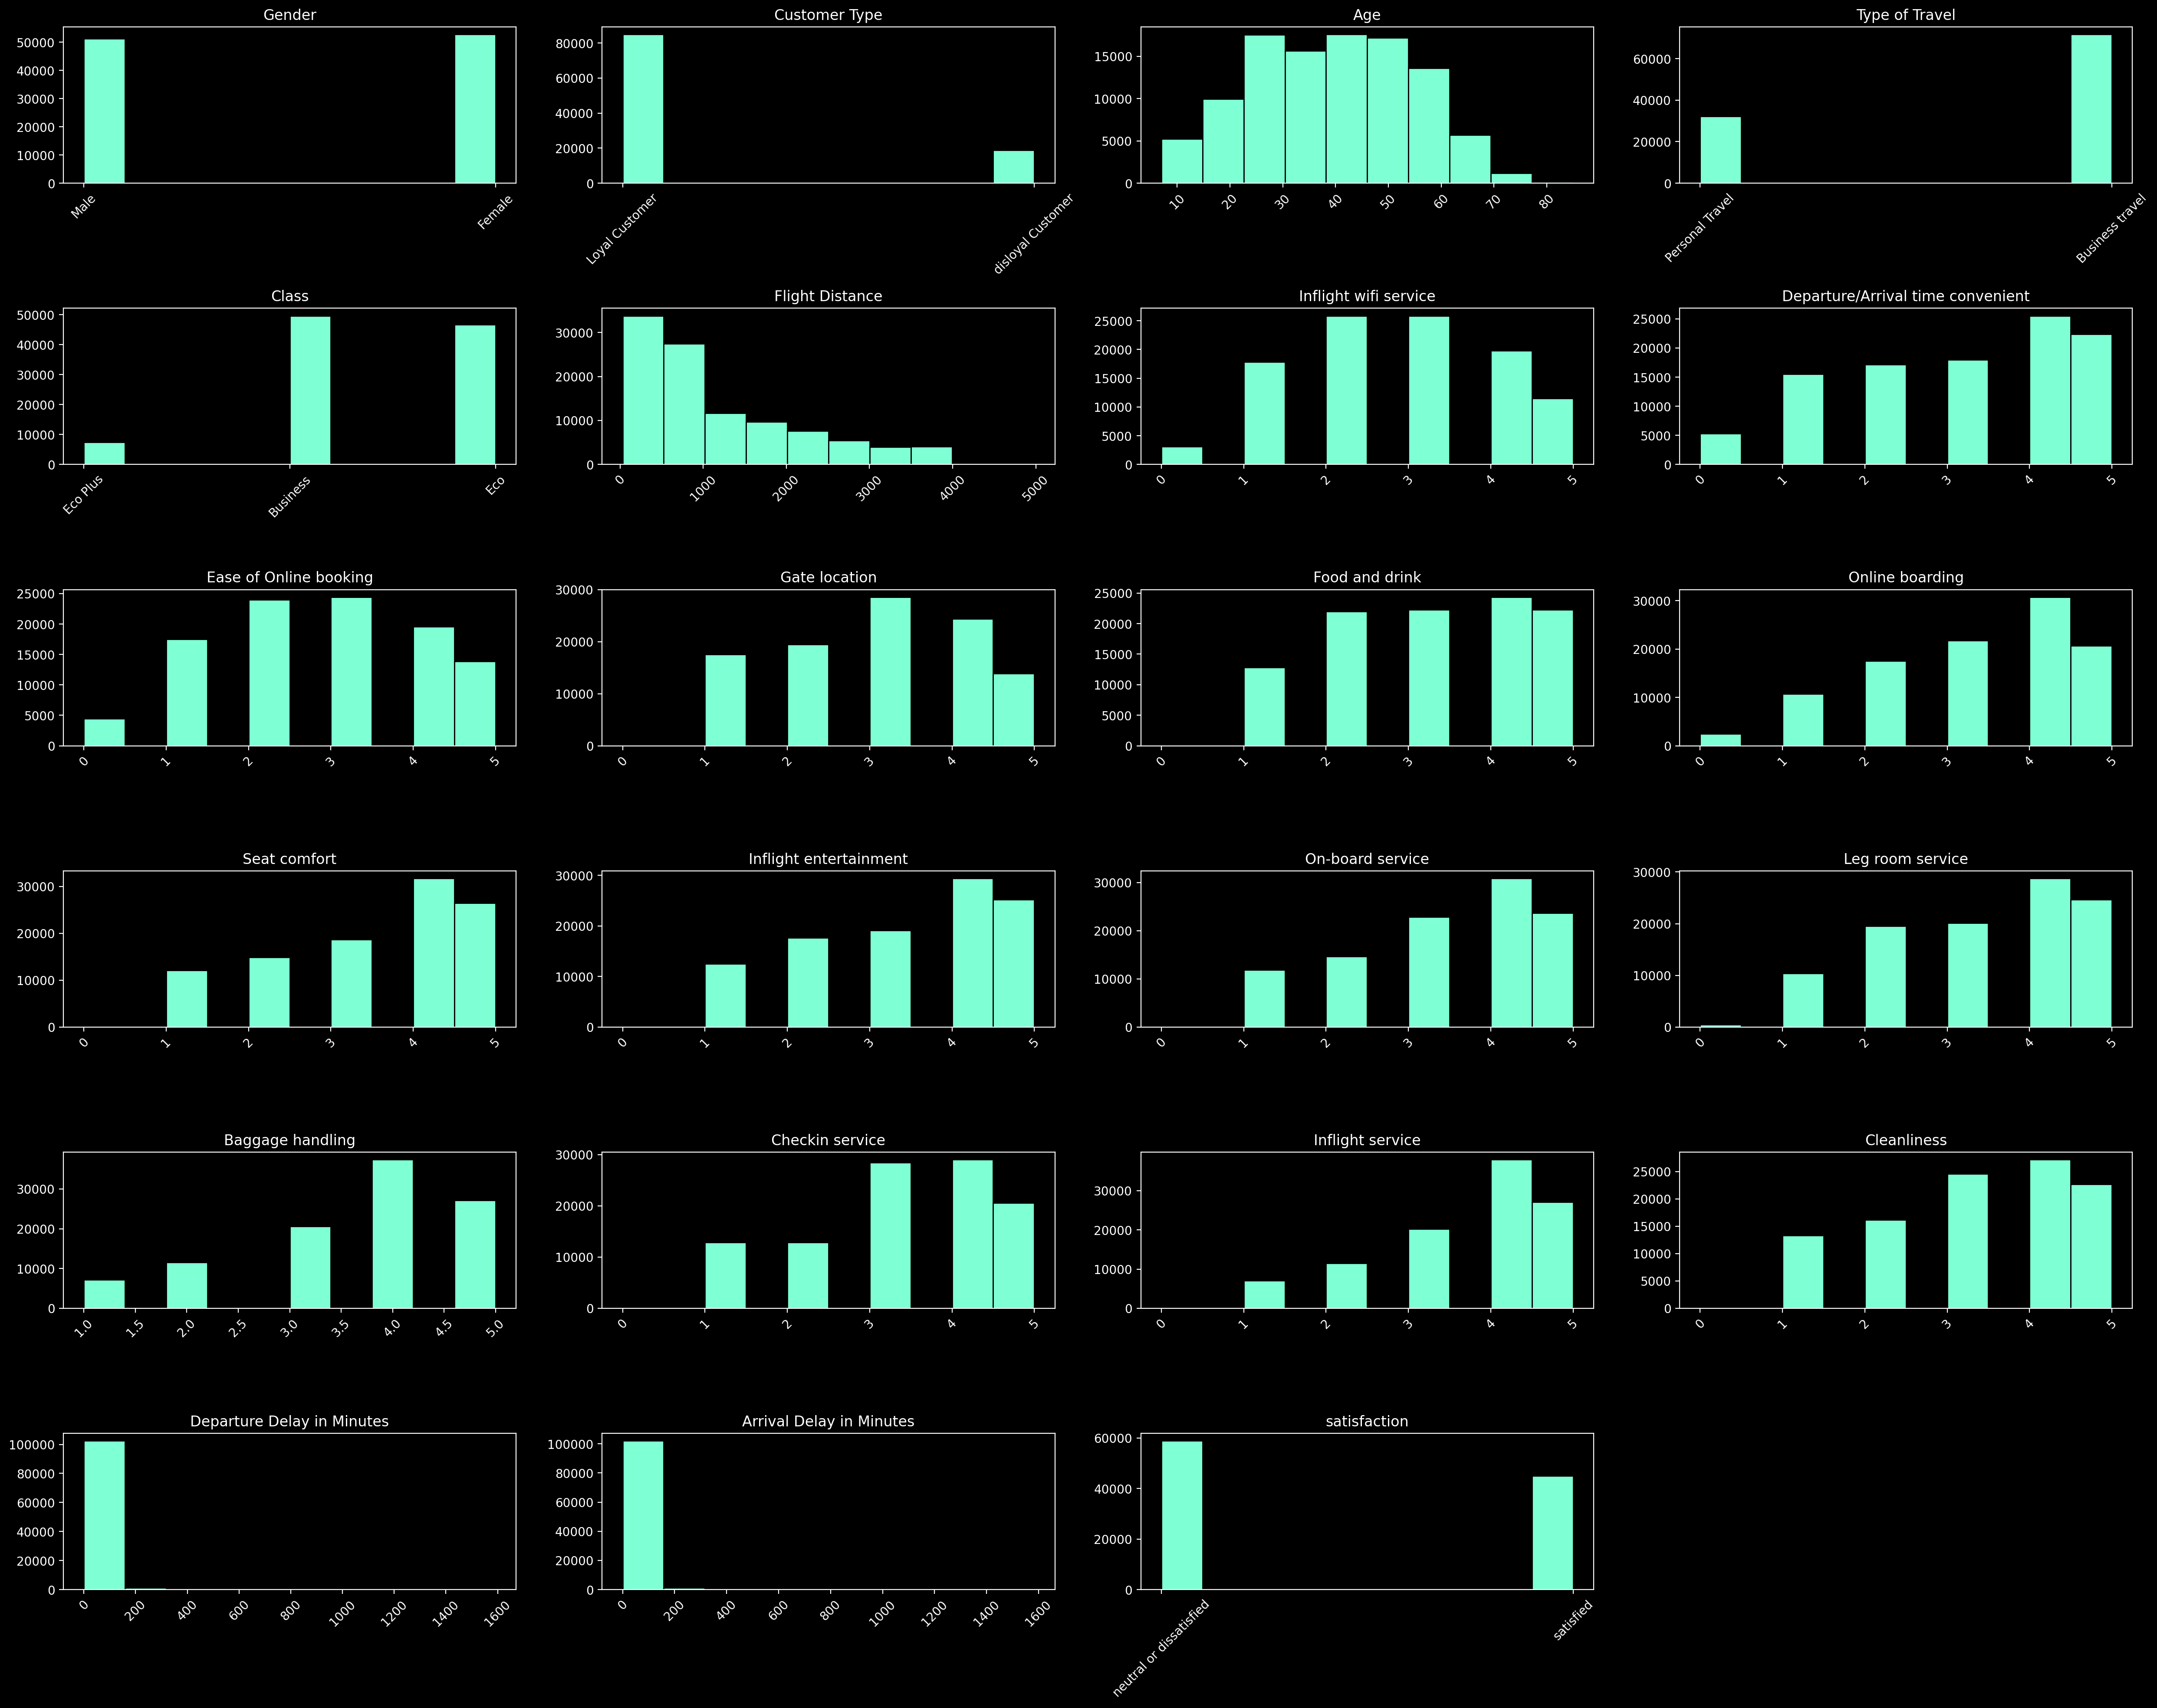

In [36]:
# set the colormap
# Plot the histogram for each variable
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(25, 25))
for i, col_name in enumerate(train.columns):
    plt.subplot(8, 4, i+1)
    train[col_name].hist(color="aquamarine", edgecolor='black')
    plt.title(col_name)
    plt.grid(False)
    plt.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

> ***
>### _`From Some data Exploration, we can conclude that:`_ 
>- only *Arrival Delay in Minutes* has Na values and is only 310 rows out of 103904 rows which we can easily drop and not consider. It is the only float column , the rest are int or categorical
>- All columns has  numerical   values expect the following columns are categorical  with no Nulls. 
> ***
>| Column    | Unique values |
>| -------- | ------- |
>| Gender  | Male, Female  |
>| Customer Type    | Loyal Customer, disloyal Customer   |
>| Class    | Eco Plus, Business, Eco   |
>| Type of Travel | Personal Travel, Business travel    |
>| satisfaction    | neutral or dissatisfied, satisfied   |
>- The following columns are continous values that we can do some thresholding on them to convert them to categorical ones
> ***
>| Column    | 
>| -------- | 
>| Age    | 
>| Flight Distance | 
>| Departure Delay in minutes|
>| Arrival Delay in minutes| 
>- However, from the histogram, it seems that Departure Delay & Arrival delay are very  +vely skewed ,and has no clear distinguish, so we can drop them as they donot convey clear info. 
>- Since we will drop "Arrival Delay in Minutes" column, we no longer need to drop Na rows
>- The rest of the columns are has int values that ranges from 0-5 as they are ratings.
>- All columns need to be changed to one hot encoding as apriori needs it in this format 
> ***

In [37]:
train=train.drop(["Departure Delay in Minutes","Arrival Delay in Minutes"], axis=1)

In [38]:
# lets categories the age column into 3 groups 
train['Age']=pd.cut(train['Age'], bins=[0, 18, 65, 100], labels=['child', 'adult', 'elderly'])
# lets categories the flight column into 3 groups each of equal size
train['Flight Distance']=pd.qcut(train['Flight Distance'], q=3, labels=['low', 'medium', 'high'])

In [39]:
#change the data type of the columns to be able to one hot encode them
for i in train.columns:
    train[i] = train[i].astype('str')

# change the categorical data to one hot encoded different columns 
# as the apriori algorithm takes only numerical data 
train_encoded = pd.get_dummies(train)

> ***
> ##### _`Now we are basically ready to train Apriori model after having a small data cleaning and exploring`_
> _`Lets remember some terminologies:`_
> - _`Support: frequency of itemset in all the transactions`_
> - _`Confidence: Conditional Probability. {X->Y} = `_  $ \frac{X and Y}{X} $
> - _`Lift: the ratio of the observed frequency of two items occurring together to the frequency that would be expected if the two items were independent. It helps  identify strong associations between items.`_
>
> _`A lift value greater than 1 indicates that the two items are positively associated, meaning that they are more likely to be purchased together than if they were independent.`_
> ***


In [40]:
frequent_itemsets = apriori(train_encoded, min_support=0.35, use_colnames=True)

/opt/anaconda3/envs/arm/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [41]:
print("The total itemset found = ",len(frequent_itemsets))
pd.set_option('display.max_colwidth', None) 
display(frequent_itemsets.tail())

The total itemset found =  39


,support,itemsets
34,0.386539,"(Type of Travel_Business travel, Customer Type_Loyal Customer, Class_Business)"
35,0.358793,"(satisfaction_satisfied, Type of Travel_Business travel, Customer Type_Loyal Customer)"
36,0.437692,"(Type of Travel_Business travel, Class_Business, Age_adult)"
37,0.388281,"(satisfaction_satisfied, Type of Travel_Business travel, Age_adult)"
38,0.369495,"(Type of Travel_Business travel, Customer Type_Loyal Customer, Class_Business, Age_adult)"


In [42]:
# after building the frequent itemsets we can now get the association rules
# we will use the lift metric to get the rules and mainly we are interested in the rules with lift > 1
rules_df = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [43]:
rules_df = rules_df.sort_values(['confidence', 'lift'], ascending =[False, False])

# get only the rules that has satisfaction as consequent(rhs of rule)
rules_df = rules_df[rules_df['consequents'].astype(str).str.contains('satisfaction')]

# change _ to = in the rules
rules_df['antecedents'] = rules_df['antecedents'].apply(lambda x: ', '.join(list(x)).replace('_', ' = '))
rules_df['consequents'] = rules_df['consequents'].apply(lambda x: ', '.join(list(x)).replace('_', ' = '))


# write the rules to a txt file
# rules_df.to_csv('rules.txt', sep='\t', index=False)

df_new=rules_df[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
df_new.index = range(1, len(df_new) + 1)
df_new


,antecedents,consequents,support,confidence,lift
1,Class = Eco,satisfaction = neutral or dissatisfied,0.366146,0.813862,1.436226
2,"Type of Travel = Business travel, Customer Type = Loyal Customer",satisfaction = satisfied,0.358793,0.705553,1.628201
3,"Type of Travel = Business travel, Age = adult",satisfaction = satisfied,0.388281,0.598531,1.381228
4,Type of Travel = Business travel,satisfaction = satisfied,0.401775,0.582597,1.344457
5,Type of Travel = Business travel,"satisfaction = satisfied, Age = adult",0.388281,0.563031,1.368449
6,"Customer Type = Loyal Customer, Age = adult",satisfaction = satisfied,0.371545,0.524781,1.211035
7,Type of Travel = Business travel,"satisfaction = satisfied, Customer Type = Loyal Customer",0.358793,0.520271,1.333684
8,Customer Type = Loyal Customer,satisfaction = satisfied,0.390100,0.477291,1.101443
9,Age = adult,satisfaction = satisfied,0.411437,0.469837,1.084241
10,Customer Type = Loyal Customer,"satisfaction = satisfied, Age = adult",0.371545,0.454588,1.104878


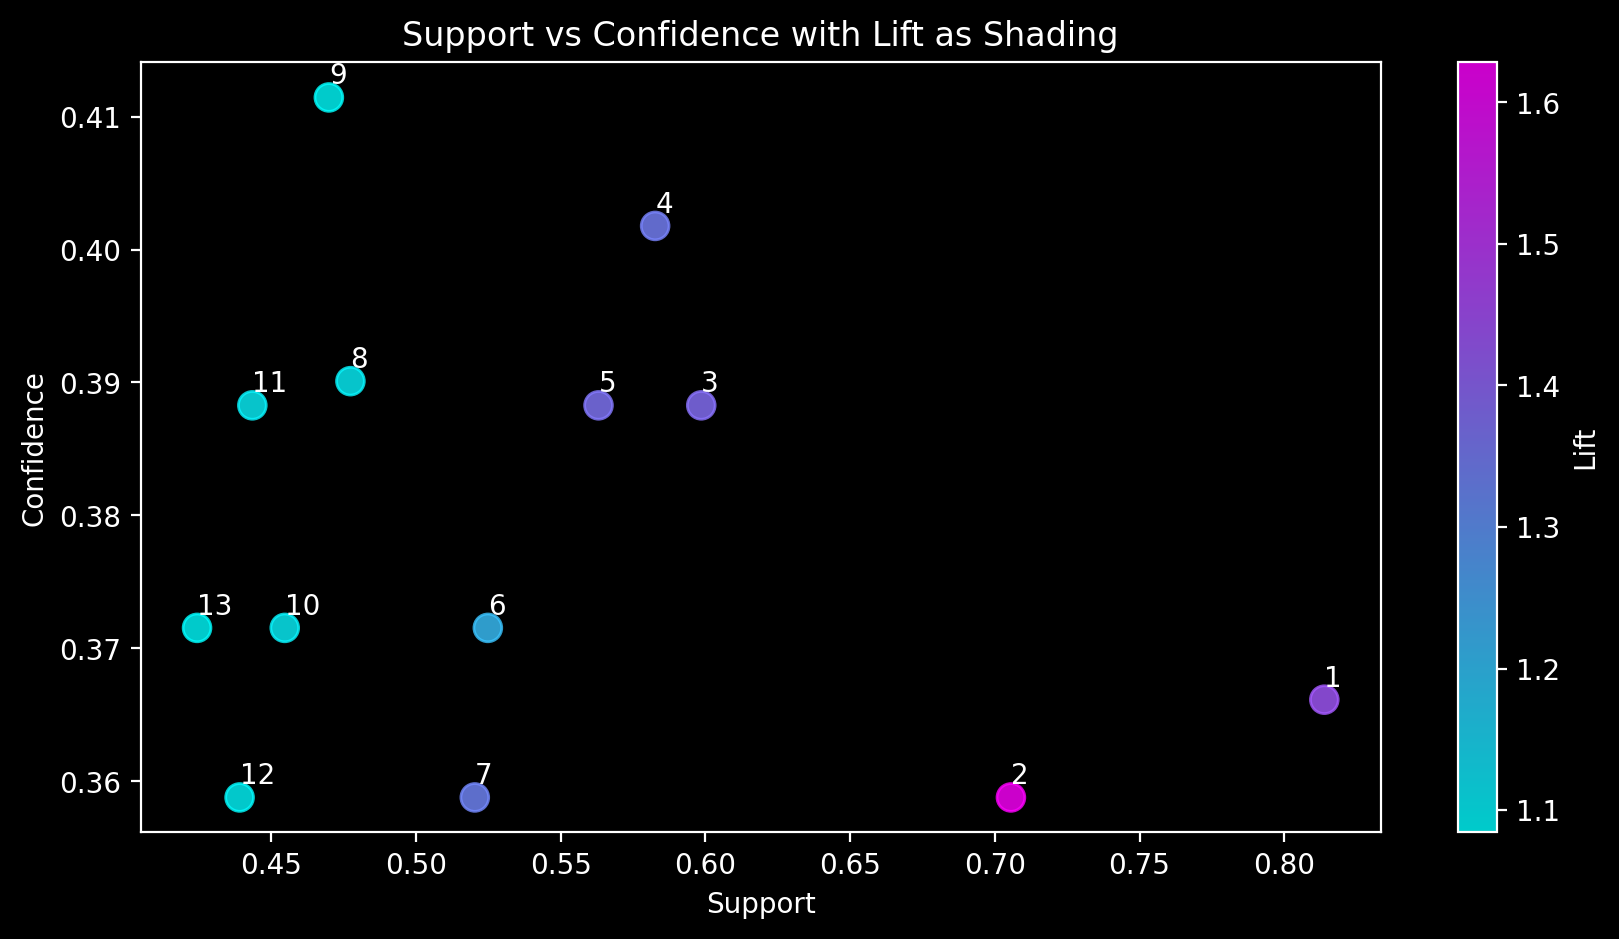

In [57]:
support=df_new['support'].values
confidence=df_new['confidence'].values
lift=df_new['lift'].values

# make background dark
plt.style.use('dark_background')
# increase dpi
plt.rcParams['figure.dpi'] = 200

# set figure size
plt.figure(figsize=(10, 5))

plt.scatter(confidence, support, c=lift, cmap='cool', s=100, alpha=0.8)

for i in range(len(support)):
    plt.annotate(str(i+1), (confidence[i], support[i]+0.001))
    # lets annotate the rule itself f"x→y"
    
# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Lift')

# Add labels and title
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence with Lift as Shading')

# Show the plot
plt.show()

> ***
>### _`The most remarkable rules are :`_
>
>| antecedent    | consequent |support | confidence  | lift   |
>| -------- | ------- |-------- | ------- |------- |
>| 'Customer Type=Loyal Customer', 'Type of Travel=Business travel' | satisfaction=satisfied |0.3587927317523868 |  0.7055528218327718 | 1.6282012304211508 |
>| 'Class=Eco' | 'satisfaction = neutral or dissatisfied' | 0.3661456729288574|  0.8138624451813029  | 1.4362262182462016 |
>
>- Those are the ones with the highest confidence and lift 
>- in general it seems that "Type of Travel"  the most potential attribute to distinguish between satisfaction and neutral or dissatisfied  as it if frequent in most of the rules generated
> ***